In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
# popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag_chang.npy'

In [4]:
mags_nsa = np.load('./nsa_sedflow/nsa_mag_data.npy').T
nsa_z = np.load('./nsa_sedflow/nsa_redshift.npy')
nsa_logm = np.load('./nsa_sedflow/nsa_logm_median.npy')

flag = ((mags_nsa[:, 0] - mags_nsa[:, 1]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 2]) > 0)
flag &= ((mags_nsa[:, 1] - mags_nsa[:, 4]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 3]) > 0)
flag &= ((mags_nsa[:, 2] - mags_nsa[:, 4]) > 0)
mags_nsa = mags_nsa[flag][:, :] # no u-band
nsa_z = nsa_z[flag]
nsa_logm = nsa_logm[flag]

#### sample flat prior on all parameters, and compute magnitude, and apply selection function

In [5]:
_prior_NDE = speculator.bounds.copy()

_prior_NDE[-2] = np.array([0.01, 0.06])
_prior_NDE[-1] = np.array([7.5, 12.5])

In [10]:
pretrain_sample = np.vstack(
    [np.random.uniform(*b, size=(10000)) for b in _prior_NDE]
).T

pretrain_sample = torch.Tensor(pretrain_sample).float()
pred_mags = speculator._predict_mag_with_mass_redshift_batch(pretrain_sample)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 15.90 GiB total capacity; 4.13 GiB already allocated; 20.75 MiB free; 4.14 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [39]:
flag = [(pred_mags.cpu().detach().numpy()[:, i] < np.percentile(mags_nsa[:, i], 98)) & (
    pred_mags.cpu().detach().numpy()[:, i] > np.percentile(mags_nsa[:, i], 1)) for i in range(5)]
flag = np.logical_and.reduce(flag)

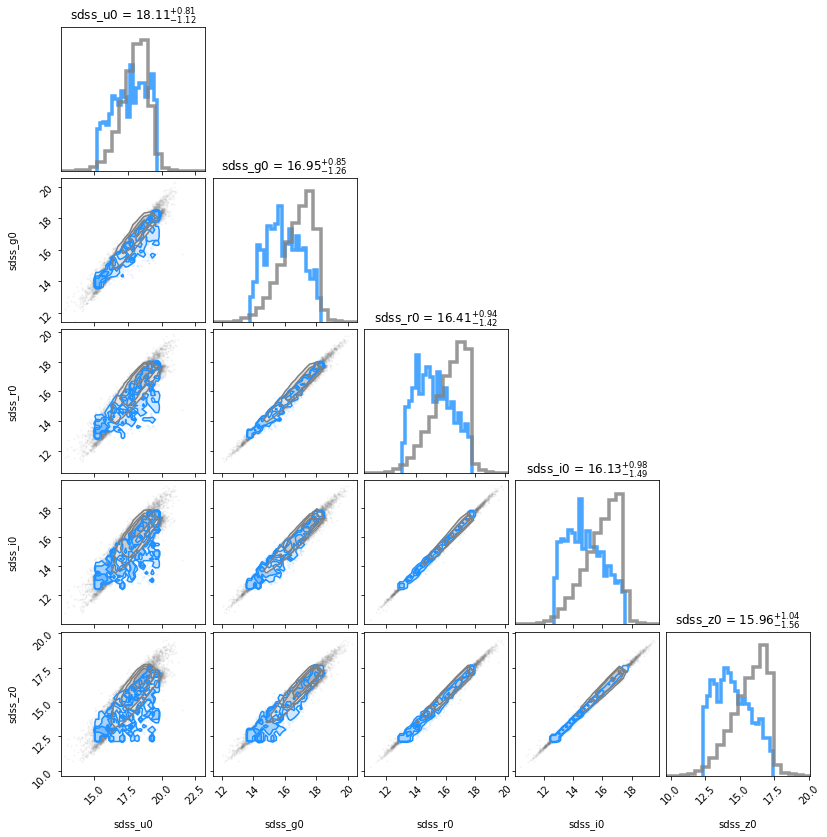

In [41]:
import matplotlib.lines as mlines

labels = filters

figure = corner.corner(pred_mags.cpu().detach().numpy()[:, :][flag], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

figure = corner.corner(mags_nsa,
                       fig=figure,
                       color='gray', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

In [40]:
np.sum(flag)

923

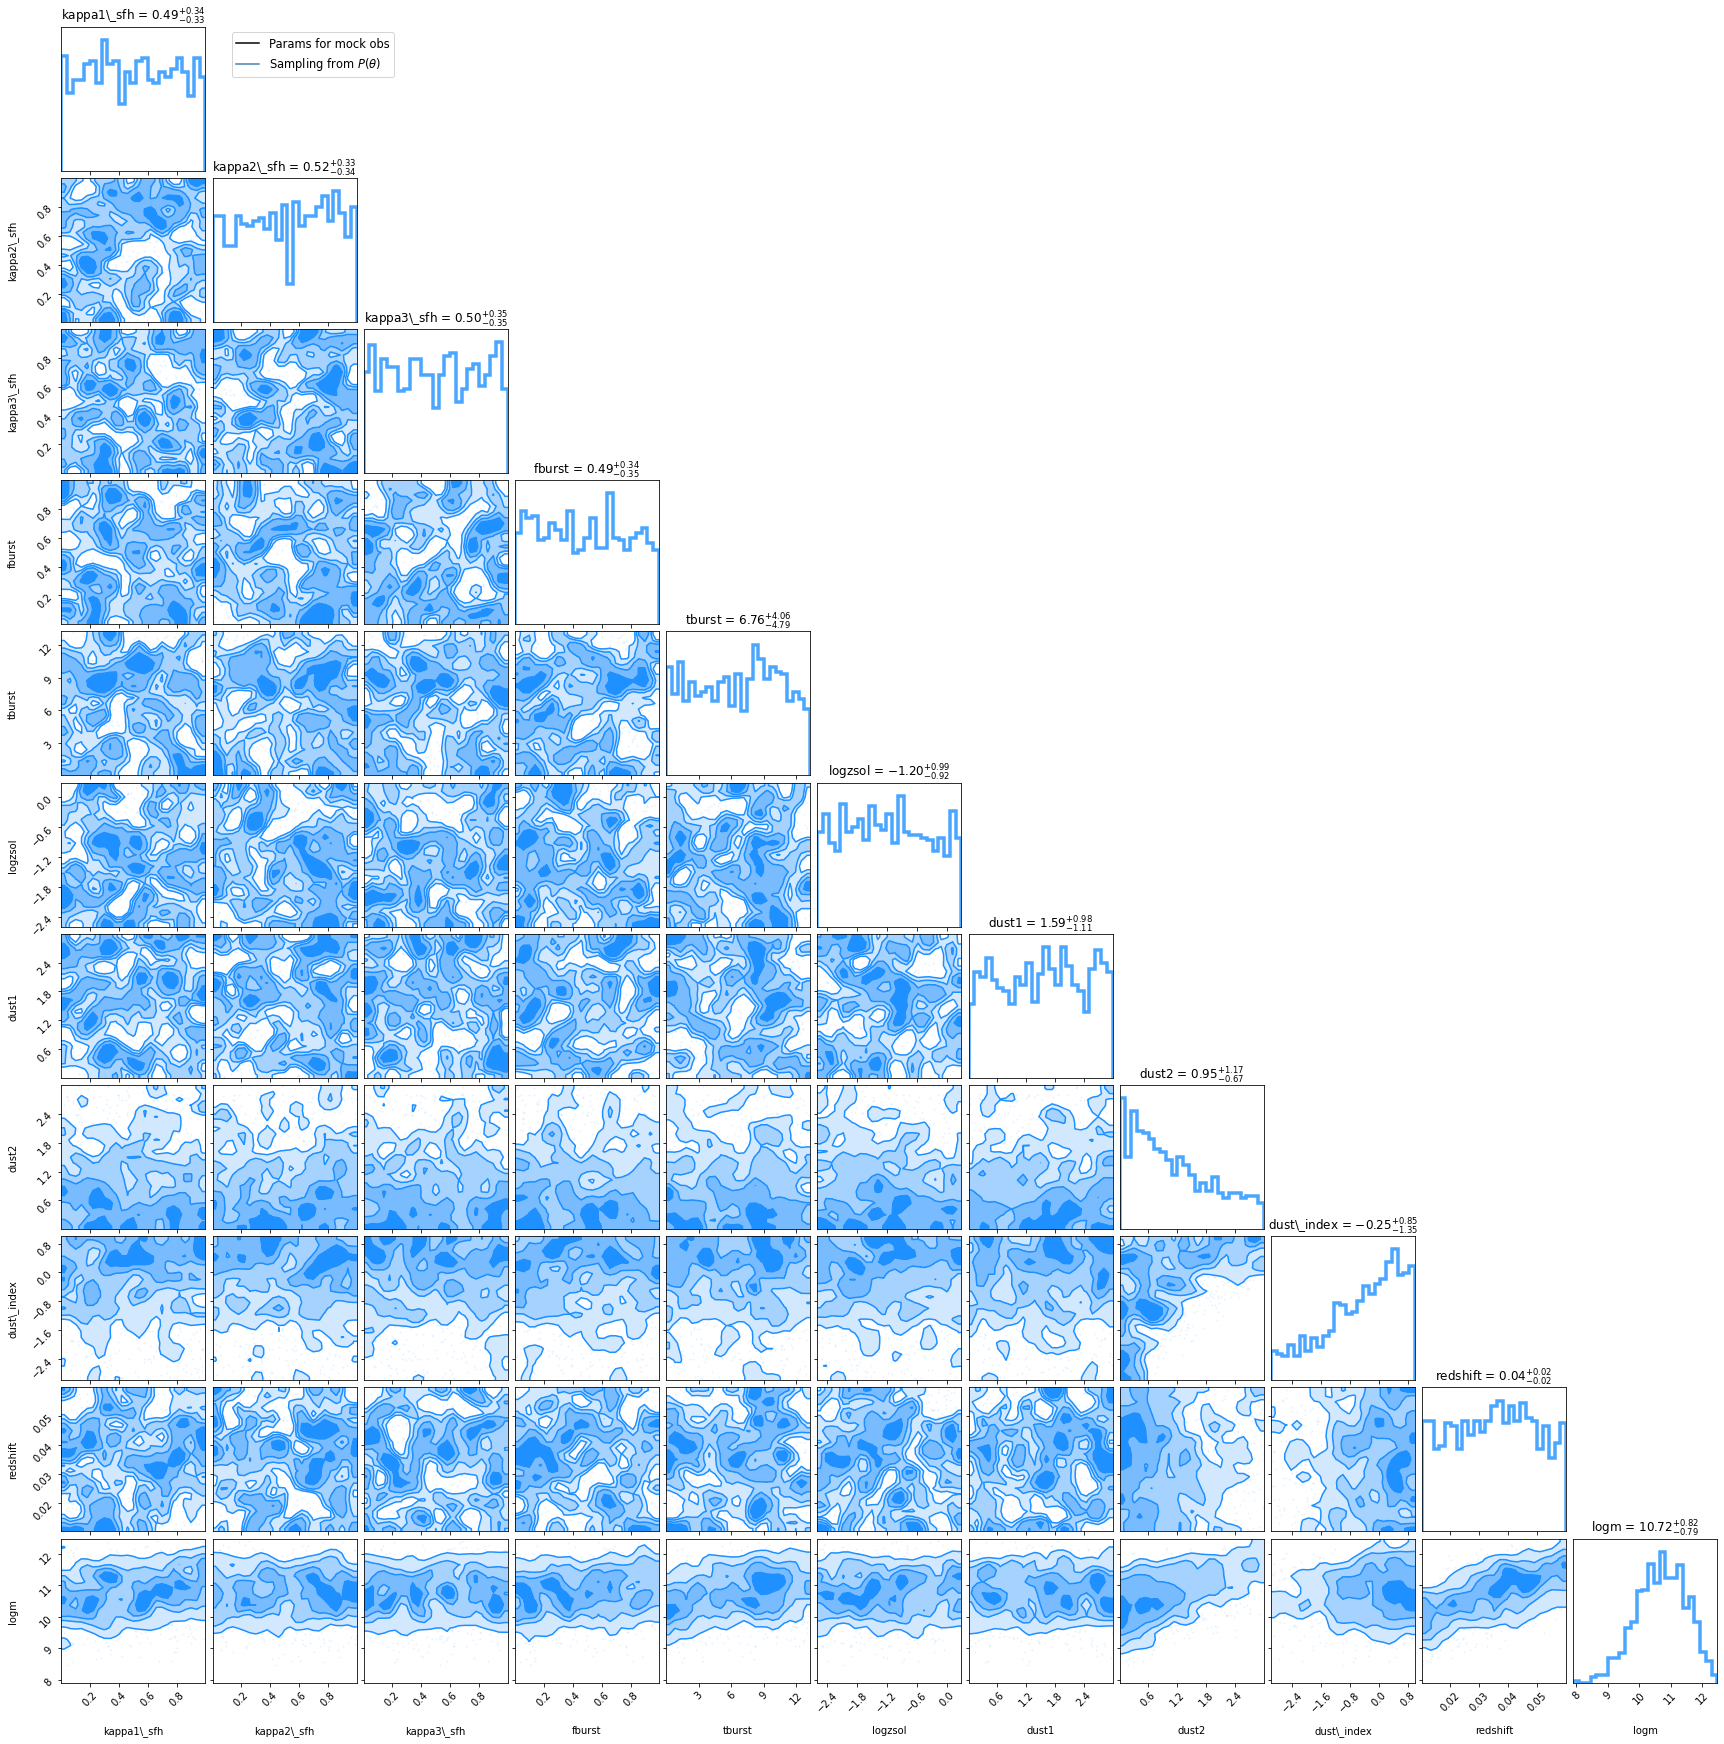

In [43]:
# samples = NDE_theta.sample(10000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]


nf_plot = corner.corner(
    pretrain_sample[flag],
#                       fig=figure, 
                        labels=labels, bins=25,
                      color='dodgerblue',
                      smooth=1, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))